# SimMAtree

In [1]:
# Install simmatree directly from GitHub

# !pip install git+https://github.com/LostMa-ERC/simMAtree.git

# Issue on dependancies with colab! Run this 2 lines alternatively:
# !pip install git+https://github.com/LostMa-ERC/simMAtree.git --no-deps
# !pip install pandas numpy matplotlib seaborn pydantic click rich pyyaml

# Test installation
!simmatree-test

2025-06-03 16:40:09.487965: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748968809.584781   20869 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748968809.617508   20869 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-03 16:40:09.694643: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
Looks good!


### Imports and Setup

In [2]:
import os
import tempfile
import yaml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Import simmatree functions directly
from src.cli.config import Config
from src.cli.generate import generate
from src.cli.inference import inference
from src.cli.score import score

### Configuration example

In [3]:
# Define experiment configuration
config_dict = {
    'model': {
        'name': 'BirthDeath', # 'Yule' or 'BirthDeath' here
        'config': {
            'n_init': 300,
            'Nact': 1000,
            'Ninact': 1000,
            'max_pop': 500000
        }
    },
    'params': {
        'LDA': 0.3,
        'lda': 0.008,
        'gamma': 0.001,
        'mu': 0.0033
    },
    'inference': {
        'name': 'SBI',
        'config': {
            'method': 'NPE',
            'num_simulations': 200,
            'num_rounds': 2,
            'random_seed': 42,
            'num_samples': 100,
            'num_workers': 2,       # Reduced for Colab? TODO : Check the optimal number here
            'device': 'cpu'
        }
    }
}

# Create temporary directory for our experiment
temp_dir = "/content/"
config_file = os.path.join(temp_dir, 'BD_example.yml')

# Save configuration to YAML file
with open(config_file, 'w') as f:
    yaml.dump(config_dict, f, default_flow_style=False)

# Parse configuration using simmatree's Config class
config = Config(config_file)

print(f"Configuration saved to: {config_file}")


Configuration saved to: /content/BD_example.yml


### Data generation

In [4]:
# Generate synthetic witness data using the Python function directly
synthetic_data_file = os.path.join(temp_dir, 'data/synthetic_data.csv')

print("Generating synthetic witness data...")
print("This simulates the copying and transmission process of manuscripts.")

# Use the generate function directly
success = generate(
    data_path=synthetic_data_file,
    model=config.model,
    parameters=config.params,
    seed=42,
    show_params=False
)

print(f"\nGeneration successful: {success}")
print(f"Synthetic data saved to: {synthetic_data_file}")

# CLI equivalent:
print(f"\n💡 CLI equivalent: simmatree -c {config_file} generate -o {synthetic_data_file} --show-params")

Generating synthetic witness data...
This simulates the copying and transmission process of manuscripts.
Generating population...
Witness Number: 1238
Works Number: 156
Max Witnesses: 37
Number of 1: 22

Generation successful: True
Synthetic data saved to: /content/data/synthetic_data.csv

💡 CLI equivalent: simmatree -c /content/BD_example.yml generate -o /content/data/synthetic_data.csv --show-params


In [5]:
# Load and examine the synthetic data
df = pd.read_csv(synthetic_data_file, sep=';')

print("📊 Dataset Overview:")
print(f"Total witnesses: {len(df)}")
print(f"Unique texts: {df['text_ID'].nunique()}")
print(f"Data shape: {df.shape}")

print("\n🔍 First 10 rows:")
print(df.head(10))

# Analyze witness distribution
witness_counts = df.groupby('text_ID')['witness_ID'].count()

print(f"\n📈 Witness Distribution Statistics:")
print(f"Mean witnesses per text: {witness_counts.mean():.2f}")
print(f"Median witnesses per text: {witness_counts.median():.1f}")
print(f"Max witnesses for one text: {witness_counts.max()}")
print(f"Texts with only 1 witness: {(witness_counts == 1).sum()}")

📊 Dataset Overview:
Total witnesses: 1238
Unique texts: 156
Data shape: (1238, 2)

🔍 First 10 rows:
  witness_ID text_ID
0       W0-1      T0
1       W1-1      T1
2       W1-2      T1
3       W1-3      T1
4       W1-4      T1
5       W1-5      T1
6       W1-6      T1
7       W1-7      T1
8       W1-8      T1
9       W1-9      T1

📈 Witness Distribution Statistics:
Mean witnesses per text: 7.94
Median witnesses per text: 6.0
Max witnesses for one text: 38
Texts with only 1 witness: 22


<ipython-input-6-988a2fe7ce2a>:16: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  axes[1].plot(x_values, y_values, 'o-', linestyle='--', marker='o',
<ipython-input-6-988a2fe7ce2a>:16: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o-" (-> marker='o'). The keyword argument will take precedence.
  axes[1].plot(x_values, y_values, 'o-', linestyle='--', marker='o',


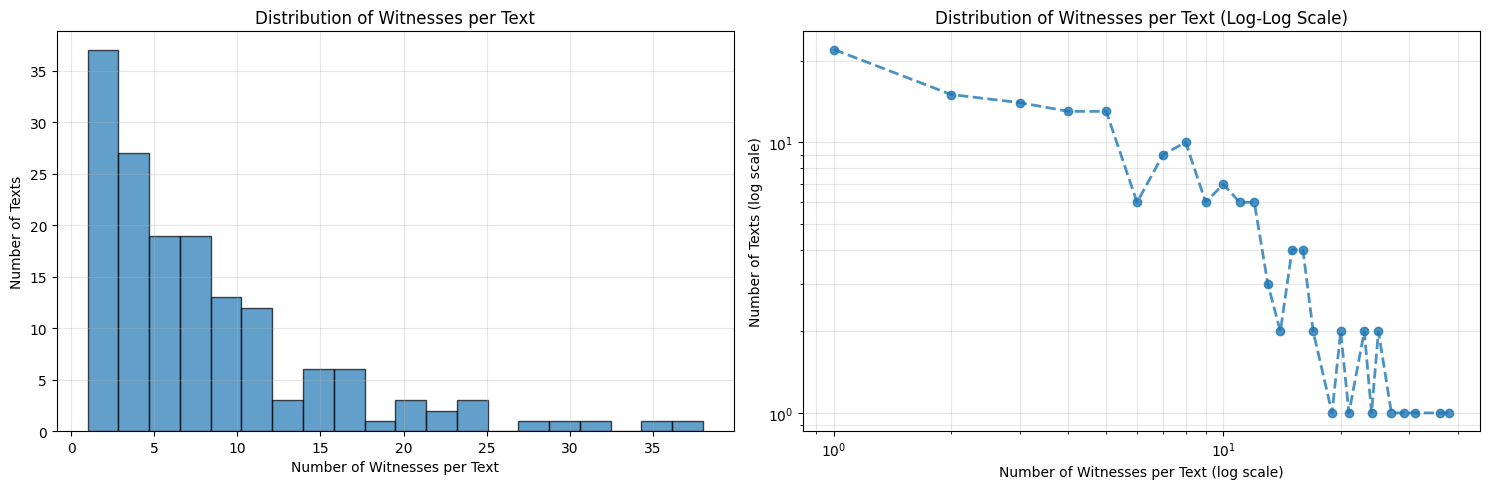

In [6]:
# Create visualization of witness distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Histogram of witness counts per text
axes[0].hist(witness_counts, bins=20, alpha=0.7, edgecolor='black')
axes[0].set_xlabel('Number of Witnesses per Text')
axes[0].set_ylabel('Number of Texts')
axes[0].set_title('Distribution of Witnesses per Text')
axes[0].grid(True, alpha=0.3)

# Log-scale version for better visualization
witness_freq = witness_counts.value_counts().sort_index()
x_values = witness_freq.index.values
y_values = witness_freq.values

axes[1].plot(x_values, y_values, linestyle='--', marker='o',
             markersize=6, linewidth=2, alpha=0.8)
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].set_xlabel('Number of Witnesses per Text (log scale)')
axes[1].set_ylabel('Number of Texts (log scale)')
axes[1].set_title('Distribution of Witnesses per Text (Log-Log Scale)')
axes[1].grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.show()


## TODO : Comparaison avec Yule sur cette distribution ? (avec une autre config)

## Bayesian Inference

This may take a few minutes depending on the configuration.

In [7]:
# Set up results directory
results_dir = Path(temp_dir) / 'inference_results'
results_dir.mkdir(exist_ok=True)

print("Running Bayesian inference...")
print("This will estimate the model parameters from the observed data.")

# Run inference using the Python function directly
inference_data = inference(
    csv_file=synthetic_data_file,
    model=config.model,
    backend=config.backend,
    dir=results_dir,
    csv_separator=';'
)

# List generated files
result_files = list(results_dir.glob('*'))
print(f"\n Generated files: {[f.name for f in result_files]}")

# CLI equivalent:
print(f"\n💡 CLI equivalent: simmatree -c {config_file} infer -i {synthetic_data_file} -o {results_dir}")


Running Bayesian inference...
This will estimate the model parameters from the observed data.
cpu


───────────────────────────────────────────────────── Dataset ─────────────────────────────────────────────────────

Data: /content/data/synthetic_data.csv

            Data observation            
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ statistics                   ┃ value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ Number of witnesses          │ 1238  │
│ Number of texts              │ 156   │
│ Max witnesses for 1 text     │ 37    │
│ Median witnesses per text    │ 5     │
│ Number of texts w/ 1 witness │ 22    │
└──────────────────────────────┴───────┘

──────────────────────────────────────────────── Running inference ────────────────────────────────────────────────

BirthDeath

Training device: cpu
Simulation device: cpu
Running simulations...
ROUND 1


  0%|          | 0/200 [00:00<?, ?it/s]


48 zero occurrences out of 200 simulations (24.00%)
48 BREAK occurrences out of 200 simulations (24.00%)

 Neural network successfully converged after 191 epochs.

Drawing 100000 posterior samples:   0%|          | 0/100000 [00:00<?, ?it/s]

ROUND 2
The `RestrictedPrior` rejected 72.0% of prior samples. You will get a speed-up of 257.4%.


  0%|          | 0/200 [00:00<?, ?it/s]


0 zero occurrences out of 200 simulations (0.00%)
51 BREAK occurrences out of 200 simulations (25.50%)

 Neural network successfully converged after 77 epochs.

Drawing 100000 posterior samples:   0%|          | 0/100000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Running posterior predictive checks...


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

───────────────────────────────────────────────── Writing results ─────────────────────────────────────────────────

Output directory:  /content/inference_results

Number of witnesses: 5 outlier values excluded (>100000)
Number of works: 5 outlier values excluded (>100000)
Max. number of witnesses per work: 5 outlier values excluded (>100000)
Med. number of witnesses per work: 5 outlier values excluded (>100000)
Number of witnesses with one work: 5 outlier values excluded (>100000)

 Generated files: ['obs_values.npy', 'relative_error.png', 'summary_metrics.csv', 'posterior_summary.csv', 'posterior_predictive.npy', 'posterior.png', 'pairplot.png', 'posterior_samples.npy', 'pp_summaries.png']

💡 CLI equivalent: simmatree -c /content/BD_example.yml infer -i /content/data/synthetic_data.csv -o /content/inference_results


In [8]:

# Load posterior summary
posterior_summary = pd.read_csv(results_dir / 'posterior_summary.csv')

print(" Posterior Summary Statistics:")
print(posterior_summary.round(6))

# Compare with true parameters
true_params = config.params
estimated_params = posterior_summary['hpdi_95%'].values

param_names = ['lda', 'mu']
true_values = [true_params[name] for name in param_names]

print(f"\n Parameter Comparison:")
print(f"{'Parameter':<10} {'True Value':<12} {'HPDI Point':<12} {'Relative Error':<15}")
print("-" * 55)

for i, name in enumerate(param_names):
    true_val = true_values[i]
    estimated_val = estimated_params[i]
    rel_error = abs(estimated_val - true_val) / true_val * 100
    print(f"{name:<10} {true_val:<12.6f} {estimated_val:<12.6f} {rel_error:<15.2f}%")

📊 Posterior Summary Statistics:
   Unnamed: 0      mean       std        5%       50%       95%  hpdi_95%
0           0  0.008221  0.003139  0.003384  0.007969  0.013491  0.007694
1           1  0.003302  0.001676  0.000683  0.003098  0.006302  0.002962

🎯 Parameter Comparison:
Parameter  True Value   HPDI Point   Relative Error 
-------------------------------------------------------
lda        0.008000     0.007694     3.83           %
mu         0.003300     0.002962     10.26          %



📈 Parameter Correlations and Posterior Distributions


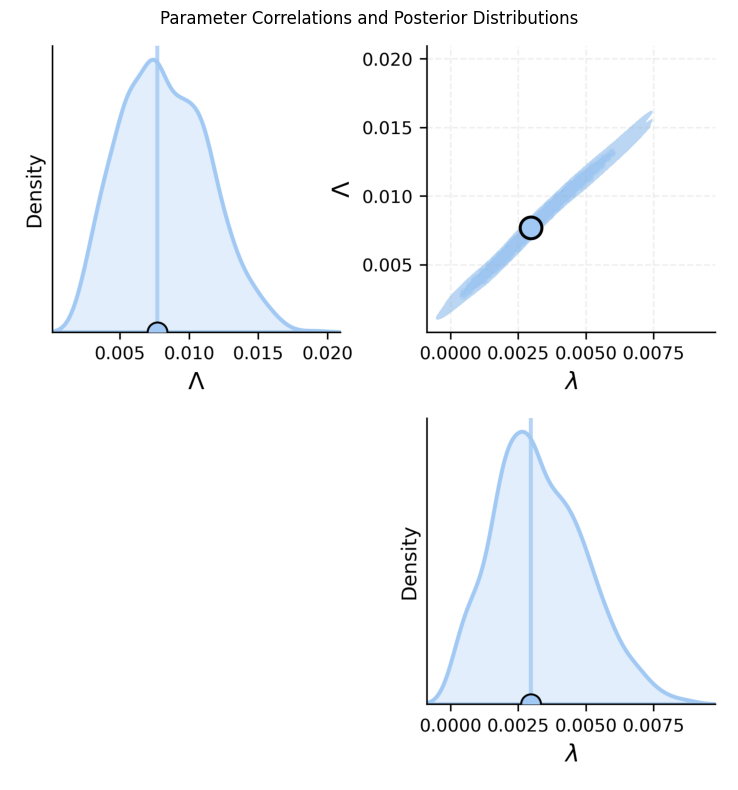


📈 Marginal Posterior Distributions


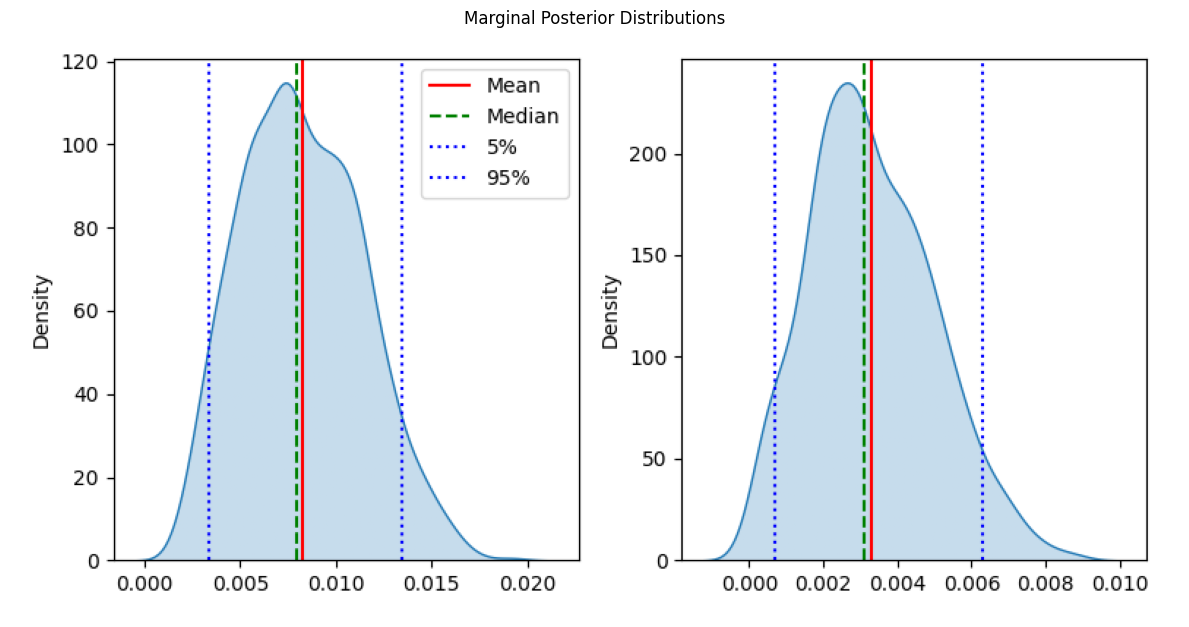


📈 Posterior Predictive Checks


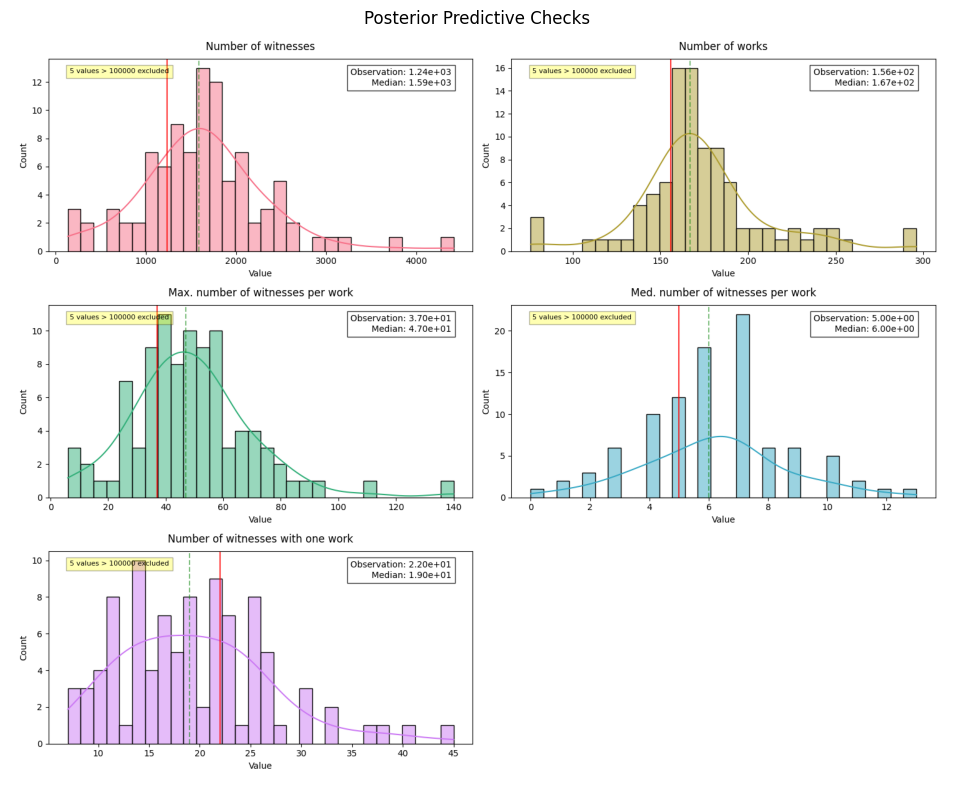

In [9]:
# Display generated plots
from IPython.display import Image, display
import matplotlib.image as mpimg

# Show posterior distributions
plots_to_show = [
    ('pairplot.png', 'Parameter Correlations and Posterior Distributions'),
    ('posterior.png', 'Marginal Posterior Distributions'),
    ('pp_summaries.png', 'Posterior Predictive Checks')
]

for plot_file, title in plots_to_show:
    plot_path = results_dir / plot_file
    if plot_path.exists():
        print(f"\n{title}")
        img = mpimg.imread(plot_path)
        plt.figure(figsize=(12, 8))
        plt.imshow(img)
        plt.axis('off')
        plt.title(title)
        plt.tight_layout()
        plt.show()
    else:
        print(f" Plot not found: {plot_file}")

As we have here the ground truth, we can evaluate how accurate we are in our inference :

In [10]:
print("Evaluating inference performance against true parameters...")

params_BD = {'lda': config.params['lda'], 'mu': config.params['mu']}

# Run scoring using the Python function directly
score(param_dict=params_BD, results_dir=str(results_dir))

# Load evaluation metrics
metrics_file = results_dir / 'summary_metrics.csv'
if metrics_file.exists():
    metrics = pd.read_csv(metrics_file)
    print("\n Evaluation Metrics:")
    print(metrics.round(6))

    print(f"\n Performance Summary:")
    print(f"Root Mean Square Error (RMSE): {metrics['rmse'].iloc[0]:.6f}")
    print(f"Normalized RMSE: {metrics['nrmse'].iloc[0]:.6f}")
    print(f"Mean Relative Error: {metrics['mean_rel_error_pct'].iloc[0]:.2f}%")
    print(f"Coverage Probability: {metrics['coverage_probability'].iloc[0]:.2f}")
else:
    print(" Evaluation metrics file not found.")

# CLI equivalent:
print(f"\n💡 CLI equivalent: simmatree -c {config_file} score -d {results_dir}")

Evaluating inference performance against true parameters...
Number of witnesses: 5 outlier values excluded (>100000)
Number of works: 5 outlier values excluded (>100000)
Max. number of witnesses per work: 5 outlier values excluded (>100000)
Med. number of witnesses per work: 5 outlier values excluded (>100000)
Number of witnesses with one work: 5 outlier values excluded (>100000)

=== Summary of Evaluation Metrics ===
rmse: 0.00032272498824284583
nrmse: 0.07740314041193118
mean_rel_error_pct: 7.041563825757574
coverage_probability: 1.0

=== Parameter-Specific Metrics ===

lda:
  true_value: 0.008
  hpdi_point: 0.007693783
  post. mean: 0.008220654
  rel_error_pct: 3.8277125000000014
  norm_squared_error: 0.0014651382982656263
  bias: -0.0003062170000000001
  hpdi_interval: (0.0028948274906724692, 0.014603094174526631)
  in_hpdi_95: True

mu:
  true_value: 0.0033
  hpdi_point: 0.0029615713
  post. mean: 0.0033018354
  rel_error_pct: 10.255415151515146
  norm_squared_error: 0.01051735399


Parameter Correlations and Posterior Distributions


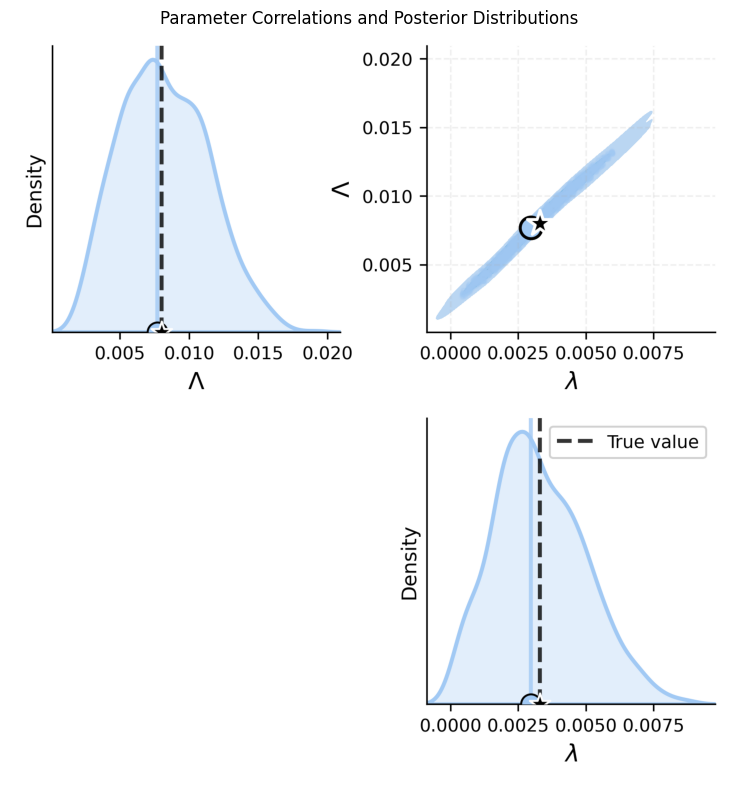


Marginal Posterior Distributions


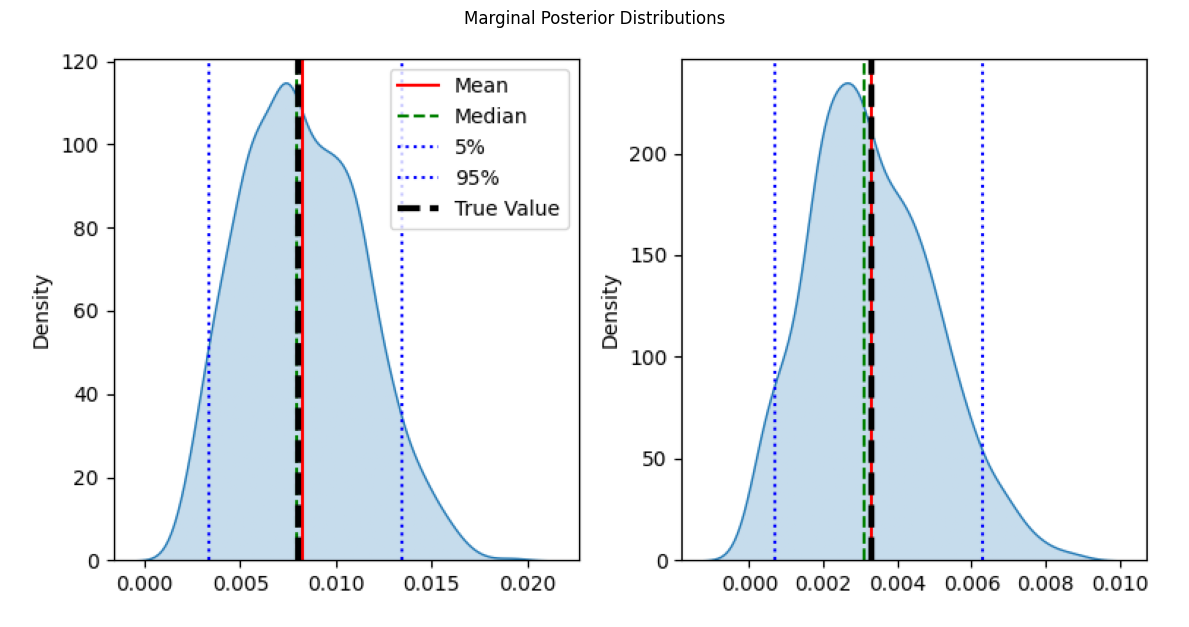


Relative error of estimates


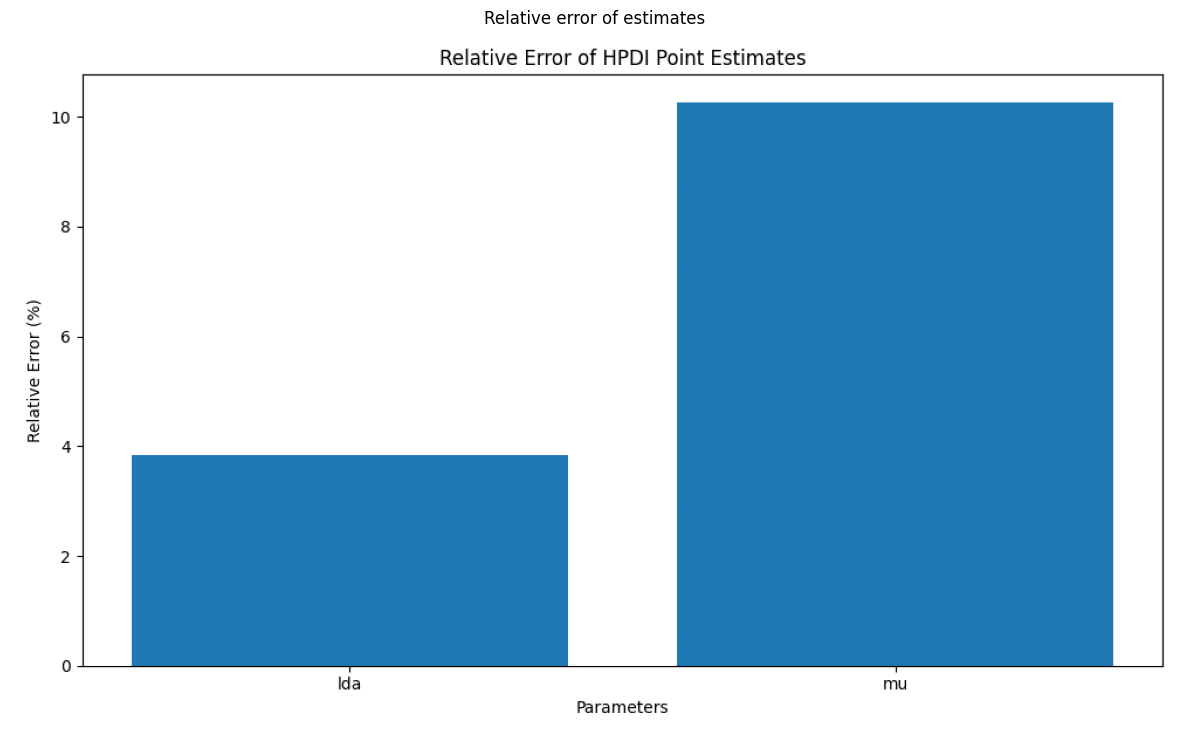

In [13]:
# Display generated plots
from IPython.display import Image, display
import matplotlib.image as mpimg

# Show posterior distributions
plots_to_show = [
    ('pairplot.png', 'Parameter Correlations and Posterior Distributions'),
    ('posterior.png', 'Marginal Posterior Distributions'),
    ('relative_error.png', 'Relative error of estimates')
]

for plot_file, title in plots_to_show:
    plot_path = results_dir / plot_file
    if plot_path.exists():
        print(f"\n{title}")
        img = mpimg.imread(plot_path)
        plt.figure(figsize=(12, 8))
        plt.imshow(img)
        plt.axis('off')
        plt.title(title)
        plt.tight_layout()
        plt.show()
    else:
        print(f" Plot not found: {plot_file}")